# Host-guest complex setup and simulation using SMIRNOFF

This notebook takes a SMILES string for a guest and a 3D structure for a host, and generates an initial structure of the complex using docking. It then proceeds to solvate, parameterize the system, and then minimize and do a short simulation with OpenMM.

Please note this is intended for educational purposes and comprises a worked example, not a polished tool. The usual disclaimers apply -- don't take anything here as advice on how you should set up these types of systems; this is just an example of setting up a nontrivial system with SMIRNOFF.

*Author - David Mobley (UC Irvine)*

## Prerequisites

We'll assume you have installed the course prerequisites as detailed in the [getting started instructions](https://github.com/MobleyLab/drug-computing/blob/master/uci-pharmsci/getting-started.md) for this course.

## Import some tools we need initially
(Let's do this early so you can fail quickly if you don't have the tools you need)

In [4]:
from openeye import oechem # OpenEye Python toolkits

# Check license
print("Is your OEChem licensed? ", oechem.OEChemIsLicensed())
from openeye import oeomega # Omega toolkit
from openeye import oequacpac #Charge toolkit
from openeye import oedocking # Docking toolkit

try:
    import openmm
    from openmm import app, unit
    from openmm.app import PDBFile
except ImportError:
    from simtk import openmm, app, unit
    from simtk.openmm.app import PDBFile

# import openff tools
from openff.toolkit.typing.engines.smirnoff import *
import os

# If you get an error with this, you may need to conda-install pdbfixer:
from pdbfixer import PDBFixer # for solvating

Is your OEChem licensed?  True


## Configuration for your run

We'll use this to configure where to get input files, where to write output files, etc. We draw on the SAMPL7 blind challenge for host-guest binding.

In [5]:
# Where will we write outputs? Directory will be created if it does not exist
datadir = 'datafiles'

# Where will we download the host file from? The below is an uncharged host
host_source = 'https://raw.githubusercontent.com/samplchallenges/SAMPL7/master/host_guest/GDCC_and_guests/host_files/exoOA.mol2' #Exo octa acid
#host_source = 'exoOA.mol2'

# What SMILES string for the guest? Should be isomeric SMILES
# See https://github.com/samplchallenges/SAMPL7/blob/master/host_guest/GDCC_and_guests/guest_files/GDCC_guest_smiles.txt 
# for more SAMPL7 
guest_smiles = 'CCCCCC([O-])=O' # SAMPL7 guest 1

# Another useful source of host-guest files is the benchmarksets repo, e.g. github.com/mobleylab/benchmarksets
# This notebook has also been tested on CB7 Set 1 host-cb7.mol2 with SMILES CC12CC3CC(C1)(CC(C3)(C2)[NH3+])C.

## Quickly draw your guest and make sure it's what you intended

We'll do this as we did earlier in the class.

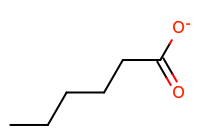

In [10]:
# Create empty OEMol
mol = oechem.OEMol()
# Convert SMILES
oechem.OESmilesToMol(mol, guest_smiles)

# Draw
from IPython.display import Image
import openeye.oedepict as oedepict # Use OpenEye depiction toolkit
oedepict.OEPrepareDepiction(mol)
oedepict.OERenderMolecule("DepictGuest.png", mol)
Image('DepictGuest.png',width = 200)


# Get host file and prep it for docking
(Note that we are going to skip charge assignment for the purposes of this example, because it's slow. So you want to use an input file which has provided charges, OR add charge assignment.)

## Retrieve host file, do file bookkeeping

In [11]:
# Output host and guest files
if not 'http' in host_source:
    hostfile = os.path.join(datadir, host_source)
else: 
    hostfile = os.path.join(datadir, os.path.basename(host_source))
guestfile = os.path.join(datadir, 'guest.mol2')

# Create data dir if not present
if not os.path.isdir(datadir):
    os.mkdir(datadir)

# Set host file name and retrieve file
if 'http' in host_source:
    import urllib
    urllib.request.urlretrieve(host_source, hostfile)
else:
    import shutil
    shutil.copy(host_source, hostfile)

## Assign partial charges to host

**(Skip this step -- which is slow -- if you are using the exoOA example provided, as it'll save you a good deal of time).**

We do this here because otherwise, OpenFF will attempt to assign charges to the host, but this will cause problems for technical reasons relating to conformer generation for macrocyclic systems (which these hosts are).

In [12]:
# Make file name for charged host
hostfile_charged = hostfile.replace('.mol2', '_charged.mol2')

import openeye.oechem as oechem
import openeye.oequacpac as quacpacpac

# Read molecule
host_mol = oechem.OEMol()
ifile = oechem.oemolistream(hostfile)
oechem.OEReadMolecule(ifile, host_mol)
ifile.close()

#Assign charges
oequacpac.OEAssignCharges(host_mol, oequacpac.OEAM1BCCCharges())

# Write out molecule
ofile= oechem.oemolostream(hostfile_charged)
oechem.OEWriteMolecule(ofile, host_mol)
ofile.close()

## Prep host file for docking

Here we'll load the host and prepare for docking, which takes a bit of time as it has to get prepared as a "receptor" for docking into

In [13]:
# Read in host file
hostfile_charged = hostfile.replace('.mol2', '_charged.mol2')
ifile = oechem.oemolistream(hostfile_charged)
host = oechem.OEMol()
oechem.OEReadMolecule( ifile, host)
ifile.close()

# Prepare a receptor - Start by getting center of mass to use as a hint for where to dock
com = oechem.OEFloatArray(3)
oechem.OEGetCenterOfMass(host, com) 

# Create receptor, as per https://docs.eyesopen.com/toolkits/python/dockingtk/receptor.html#creating-a-receptor
receptor = oechem.OEGraphMol()
oedocking.OEMakeReceptor(receptor, host, com[0], com[1], com[2])

True

## Generate 3D structure of our guest and dock it

In [14]:
#initialize omega for conformer generation
omega = oeomega.OEOmega()
omega.SetMaxConfs(100) #Generate up to 100 conformers since we'll use for docking
omega.SetIncludeInput(False)
omega.SetStrictStereo(True) #Refuse to generate conformers if stereochemistry not provided

#Initialize charge generation
chargeEngine = oequacpac.OEAM1BCCCharges()

# Initialize docking
dock = oedocking.OEDock()
dock.Initialize(receptor)

# Build OEMol from SMILES
# Generate new OEMol and parse SMILES
mol = oechem.OEMol()
oechem.OEParseSmiles( mol, guest_smiles)
# Set to use a simple neutral pH model 
oequacpac.OESetNeutralpHModel(mol)

# Generate conformers with Omega; keep only best conformer
status = omega(mol)
if not status:
    print("Error generating conformers for %s." % (guest_smiles))
    #print(smi, name, mol.NumAtoms()) #Print debug info -- make sure we're getting protons added as we should

# Assign AM1-BCC charges
oequacpac.OEAssignCharges(mol, chargeEngine)

# Dock to host
dockedMol = oechem.OEGraphMol()
status = dock.DockMultiConformerMolecule(dockedMol, mol) #By default returns only top scoring pose
sdtag = oedocking.OEDockMethodGetName(oedocking.OEDockMethod_Chemgauss4)
oedocking.OESetSDScore(dockedMol, dock, sdtag)
dock.AnnotatePose(dockedMol)

# Write out docked pose if docking successful
if status == oedocking.OEDockingReturnCode_Success:
    outmol = dockedMol

    # Write out
    tripos_mol2_filename = os.path.join(os.path.join(datadir, 'docked_guest.mol2'))
    ofile = oechem.oemolostream( tripos_mol2_filename )
    oechem.OEWriteMolecule( ofile, outmol)
    ofile.close()

    # Clean up residue names in mol2 files that are tleap-incompatible: replace substructure names with valid text.
    infile = open( tripos_mol2_filename, 'r')
    lines = infile.readlines()
    infile.close()
    newlines = [line.replace('<0>', 'GUEST') for line in lines]
    outfile = open(tripos_mol2_filename, 'w')
    outfile.writelines(newlines)
    outfile.close()
else:
    raise Exception("Error: Docking failed.")

## Visualize in 3D to make sure we placed the guest into the binding site
This is optional, but very helpful to make sure you're starting off with your guest in the binding site.

In [15]:
import py3Dmol
#First we assign the py3Dmol.view as viewer
viewer = py3Dmol.view()
#load host
viewer.addModel(open('exoOA.mol2', 'r').read(),'mol2')
#load guest
viewer.addModel(open(os.path.join(datadir, 'docked_guest.mol2'), 'r').read(),'mol2')
viewer.setStyle({'stick':{}})
#Zooming into all visualized structures 
viewer.zoomTo()
#And we finally visualize the structures using the command below
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [16]:
# Optional: can use nglview and mdtraj to load and view host and guest structures
# To execute this you'll need `nglview` for visualization and `mdtraj` for working with trajectory files

# Import modules
import nglview
import mdtraj

# Load host structure ("trajectory")
traj = mdtraj.load(os.path.join(datadir, 'exoOA.mol2'))
# Load guest structure
lig = mdtraj.load(os.path.join(tripos_mol2_filename))
                  
# Figure out which atom indices correspond to the guest, for use in visualization
atoms_guest = [ traj.n_atoms+i for i in range(lig.n_atoms)]

# "Stack" host and guest Trajectory objects into a single object
complex = traj.stack(lig)

# Visualize
view = nglview.show_mdtraj(complex)
view.add_representation('spacefill', selection="all")
view.add_representation('spacefill', selection=atoms_guest, color='blue')  #Adjust guest to show as blue for contrast
# The view command needs to be the last command issued to nglview
view

NGLWidget()

# Solvate complex

Now we generate a single PDB file of our complex (host+guest) and solvate it using PDBFixer, writing the output to a PDB file in case we'd like to visualize this. We also include conterions (sodium and chloride) at a specified concentration; here that works out to be about one ion of each.

In [17]:
# Join OEMols into complex
complex = host.CreateCopy()
oechem.OEAddMols( complex, outmol)
print("Host+guest number of atoms %s" % complex.NumAtoms())

# Write out complex PDB file 
ostream = oechem.oemolostream( os.path.join(datadir, 'complex.pdb'))
oechem.OEWriteMolecule( ostream, complex)
ostream.close()

# Solvate the system using PDBFixer
fixer = PDBFixer( os.path.join(datadir, 'complex.pdb'))

# Solvate in 20 mM NaCl and water
fixer.addSolvent(padding=unit.Quantity( 1.0, unit.nanometers), ionicStrength=unit.Quantity( 20, unit.millimolar))
print("Number of atoms after applying PDBFixer: %s" % fixer.topology.getNumAtoms())


# Write file of solvated system for visualization purposes 
PDBFile.writeFile(fixer.topology, fixer.positions, open(os.path.join(datadir, 'complex_solvated.pdb'), 'w'))

Host+guest number of atoms 211
Number of atoms after applying PDBFixer: 4554


# Apply SMIRNOFF to set up the system for simulation with OpenMM

Next, we apply a SMIRNOFF force field (OpenFF 1.0, "Parsley") to the system to set it up for simulation with OpenMM (or writing out, via ParmEd, to formats for use in a variety of other simulation packages).

Prepping a system with SMIRNOFF takes basically three components:
- The structure of the system (here, the PDB file of the solvated complex coming out of PDBFixer, above)
- OEMol objects for the components of the system (here host, guest, water and ions)
- The force field XML files

Here, we do not yet have OEMol objects for the ions so our first step is to generate those, and combine it with the host and guest OEMols

## Build a list of OEMols of all our components

In [18]:
# Keep a list of OEMols of our components
oemols = [] 

# Build ions from SMILES strings
smiles = ['[Na+]', '[Cl-]']
for smi in smiles:
    mol = oechem.OEMol()
    oechem.OESmilesToMol(mol, smi)
    # Make sure we have partial charges assigned for these (monatomic, so equal to formal charge)
    for atom in mol.GetAtoms():
        atom.SetPartialCharge(atom.GetFormalCharge())

    oemols.append(mol)

# Build water reference molecule
mol = oechem.OEMol()
oechem.OESmilesToMol(mol, 'O')
oechem.OEAddExplicitHydrogens(mol)
oechem.OETriposAtomNames(mol)
oemols.append(mol)
    
# Add oemols of host and guest
oemols.append(host)
oemols.append(outmol)

# Make a separate list of the molecules we have which already have assigned partial charges, to feed in as pre-charged
charged_oemols = [ oemols[0], oemols[1], host]

## Load our force field and parameterize the system

This uses the SMIRNOFF ForceField class and SMIRNOFF XML files to parameterize the system.

In [19]:
# Load force fields for small molecules (plus default ions), water

from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
ff = ForceField('openff-2.0.0.offxml') 


# Build list of OpenFF Molecules for passing into topology creation
mols = [] # These are all molecules
charged_mols= [] # These are just those moolecules for which we assigned charges - the ions and the host
for mol in oemols:
    mols.append(Molecule.from_openeye(mol))
for mol in charged_oemols:
    charged_mols.append(Molecule.from_openeye(mol))
    
# Create OpenFF Topology
off_topology = Topology.from_openmm(openmm_topology=fixer.topology,
                                    unique_molecules=mols)

# Parametrize the system. 
# Here our host molecule has pre-assigned partial charges to (a) accelerate the calculation, and
# (b) avoid potential problems OpenEye sometimes has with generating conformers for host molecules
# (under the hood, OpenFF generates conformers for molecules before charging them)
# This is also true for ions
system = ff.create_openmm_system(off_topology, charge_from_molecules = charged_mols)


# Minimize and (very briefly) simulate our system

Here we will do an energy minimization, followed by a very very brief simulation. These are done in separate cells since OpenMM is quite slow on CPUs so you may not want to run the simulation on your computer if you are using a CPU.

## Finalize prep and energy minimize


In [20]:
import simtk.openmm as openmm

# Even though we're just going to minimize, we still have to set up an integrator, since a Simulation needs one
integrator = openmm.VerletIntegrator(2.0*unit.femtoseconds)
# Prep the Simulation using the parameterized system, the integrator, and the topology
simulation = app.Simulation(fixer.topology, system, integrator)
# Copy in the positions
simulation.context.setPositions( fixer.positions) 

# Get initial state and energy; print
state = simulation.context.getState(getEnergy = True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy before minimization (kcal/mol): %.2g" % energy)

# Minimize, get final state and energy and print
simulation.minimizeEnergy()
state = simulation.context.getState(getEnergy=True, getPositions=True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy after minimization (kcal/mol): %.2g" % energy)
newpositions = state.getPositions()

Energy before minimization (kcal/mol): 5.1e+02
Energy after minimization (kcal/mol): -1.5e+04


## Run an MD simulation of a few steps, storing a trajectory for visualization

In [21]:
# Set up NetCDF reporter for storing trajectory; prep for Langevin dynamics
import time
from mdtraj.reporters import NetCDFReporter
integrator = openmm.LangevinIntegrator(300*unit.kelvin, 1./unit.picosecond, 2.*unit.femtoseconds)

# Prep Simulation
simulation = app.Simulation(fixer.topology, system, integrator)
# Copy in minimized positions
simulation.context.setPositions(newpositions)

# Initialize velocities to correct temperature
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
# Set up to write trajectory file to NetCDF file in data directory every 100 frames
netcdf_reporter = NetCDFReporter(os.path.join(datadir, 'trajectory.nc'), 100) #Store every 100 frames
# Initialize reporters, including a CSV file to store certain stats every 100 frames
simulation.reporters.append(netcdf_reporter)
simulation.reporters.append(app.StateDataReporter(os.path.join(datadir, 'data.csv'), 100, step=True, potentialEnergy=True, temperature=True, density=True))

# Run the simulation and print start info; store timing
print("Starting simulation")
start = time.process_time()
simulation.step(1000) #1000 steps of dynamics
end = time.process_time()

# Print elapsed time info, finalize trajectory file
print("Elapsed time %.2f seconds"%(end-start))
netcdf_reporter.close()
print("Done!")

Starting simulation
Elapsed time 0.64 seconds
Done!


In [22]:
# Load stored trajectory using MDTraj; the trajectory doesn't contain chemistry info so we also load a PDB
traj= mdtraj.load(os.path.join(datadir, 'trajectory.nc'), top=os.path.join(datadir, 'complex_solvated.pdb'))

#Recenter/impose periodicity to the system
anchor = traj.top.guess_anchor_molecules()[0]
imgd = traj.image_molecules(anchor_molecules=[anchor])
traj.center_coordinates()

# View the trajectory
view = nglview.show_mdtraj(traj)
# I haven't totally figured out nglview's selection language for our purposes here, so I'm just showing two residues
# which seems (in this case) to include the host and guest plus an ion (?). 
view.add_licorice('1-2')
view

NGLWidget(max_frame=9)

In [ ]:
# Save centered trajectory for viewing elsewhere
traj.save_netcdf(os.path.join(datadir, 'trajectory_centered.nc'))

## Other things to try

The full SAMPL7 challenge inputs are available online on GitHub for the octa acid and exoOA systems, as well as the results from other participants. Some simple things you could do as a spinoff from this notebook would be:
- Dock all of the SAMPL7 guests to this host and compare their scores. How do these agree with the experimental results for binding affinities?
- Dock all of the SAMPL7 guests to this host and then energy minimize. How do the resulting scores agree with experimental results for binding affinities?
- Do a short simulation for each guest and THEN energy minimize; compare with scores before simulating.

Possibly, none of these will work that well for ranking, but it would be interesting to see how they compare with the SAMPL7 results. See https://github.com/samplchallenges/SAMPL7/blob/master/host_guest/Analysis/ExperimentalMeasurements/experimental_measurements.csv for experimental values, and see also elsewhere in the Analysis directory for the other results of participants.

In [ ]:
#Insert code to try those here, if desired.